# Test analysis

### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4
# import pandas as pd
import dask
# from wrf import to_np
# from mpl_toolkits.basemap impor                                                                                                                   t Basemap
# from datetime import datetime
# from datetime import timedelta
# from scipy import stats
# import scipy.interpolate as interp
# from dask.distributed import Client
%matplotlib inline

In [2]:
# for quantreg
# from sklearn.linear_model import QuantileRegressor
from scipy import stats

In [3]:
from functions import ccplot, binning

In [4]:
# import seaborn as sns
# Use seaborn style defaults and set default figure size
plt.style.use('tableau-colorblind10')
# sns.set_theme(style="ticks")
# plt.style.use(['science', 'notebook'])

In [5]:
# Colormap selection
xr.set_options(cmap_divergent='RdBu', cmap_sequential='YlGnBu')

In [6]:
# client = Client(n_workers=30, threads_per_worker=1, memory_limit='60GB')

### Import data

In [9]:
mfdata_DIR1 = './data/GPM_lowres_data/*.nc'
gpm = xr.open_mfdataset(mfdata_DIR1, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)
# gpm = xr.open_dataset('./data/GPM_lowres_data/*.nc')

In [10]:
# gpm = gpm.unify_chunks()
# gpm.chunks

In [11]:
gpm

<xarray.Dataset>
Dimensions:    (time: 369600, lon: 161, lat: 161)
Coordinates:
  * time       (time) datetime64[ns] 2000-06-01 ... 2021-06-30T23:30:00
  * lon        (lon) float64 60.0 60.25 60.5 60.75 ... 99.25 99.5 99.75 100.0
  * lat        (lat) float64 0.0 0.25 0.5 0.75 1.0 ... 39.25 39.5 39.75 40.0
Data variables:
    precipCal  (time, lat, lon) float32 dask.array<chunksize=(10272, 161, 161), meta=np.ndarray>

In [12]:
precip = gpm.precipCal.resample(time = '24H').sum() / 2

In [13]:
# precip = precip.chunk(dict(time=5000, lat=40, lon=40))

In [14]:
# precip = precip.unify_chunks()
# precip.chunks

In [20]:
precip

<xarray.DataArray 'precipCal' (time: 7700, lat: 161, lon: 161)>
dask.array<truediv, shape=(7700, 161, 161), dtype=float32, chunksize=(1, 161, 161), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-06-01 2000-06-02 ... 2021-06-30
  * lon      (lon) float64 60.0 60.25 60.5 60.75 61.0 ... 99.25 99.5 99.75 100.0
  * lat      (lat) float64 0.0 0.25 0.5 0.75 1.0 ... 39.0 39.25 39.5 39.75 40.0

In [21]:
mfdata_DIR2 = './data/era_pres_data/*.nc'
era = xr.open_mfdataset(mfdata_DIR2, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)
# era = xr.open_mfdataset(mfdata_DIR2, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)

In [22]:
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    era = era.reindex(latitude = era.latitude[::-1])

In [23]:
# era = era.sel(time = slice("2000-06-01 00:00:00","2004-12-31 23:00:00"))

In [24]:
# era = era.unify_chunks()
# era.chunks

In [25]:
era

,Array,Chunk
Bytes,527.92 GiB,2.02 GiB
Shape,"(188520, 29, 161, 161)","(720, 29, 161, 161)"
Count,1644 Tasks,411 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,527.92 GiB,2.02 GiB
Shape,"(188520, 29, 161, 161)","(720, 29, 161, 161)"
Count,1644 Tasks,411 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [26]:
# era = era.sel(expver=1, drop=True)

In [27]:
era = era.transpose('time', 'level', 'latitude', 'longitude')

In [28]:
# era = era.rename_dims({'longitude':'lon', 'latitude':'lat'})

In [29]:
era = era.rename({'longitude':'lon', 'latitude':'lat'})

In [30]:
era

,Array,Chunk
Bytes,527.92 GiB,2.02 GiB
Shape,"(188520, 29, 161, 161)","(720, 29, 161, 161)"
Count,1644 Tasks,411 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,527.92 GiB,2.02 GiB
Shape,"(188520, 29, 161, 161)","(720, 29, 161, 161)"
Count,1644 Tasks,411 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [31]:
q = era.q
t = era.t
w = era.w
pres = era.coords['level']

In [32]:
p1 = precip.sel(lat = 19, lon=72)
# w1 = w.sel(lat = 19, lon=72, time=slice("2015-06-01 00:00:00","2015-07-30 23:00:00"))
# t1 = t.sel(lat = 19, lon=72, time=slice("2015-06-01 00:00:00","2015-07-30 23:00:00"))
# q1 = q.sel(lat = 19, lon=72, time=slice("2015-06-01 00:00:00", "2015-07-30 23:00:00"))

In [ ]:
p1_mon

In [33]:
p1 = p1.load()
# w1 = w1.load()
# t1 = t1.load()
# q1 = q1.load()
# pres = pres.load()

KeyboardInterrupt: 

In [27]:
# # finding precipitation extremes

# temporary_precip_indx = []

# precip95 = p1.where(p1 > 0.1).quantile(0.95)
# for time in range(len(p1)):
#     if p1[time] > precip95:
#         temporary_precip_indx.append(time)

In [28]:
# np.array(temporary_precip_indx)

In [29]:
# p1 = precip.sel(time = "2000-06-02 01:00:00")
# w1 = w.sel(time = "2000-06-02 01:00:00")
# t1 = t.sel(time = "2000-06-02 01:00:00")
# q1 = q.sel(time = "2000-06-02 01:00:00")

In [27]:
def get_qs(temp, pres):
    """
    Elemental Function to determine the precipitation estimate for each value of tempreature and omega at each grid point. (func to be used in starmap multithreading)
    ------------------
    Input :
        temp : temperature value at a grid point.
        omega_da : vertical velocity value at a grid point
    Output :
        qs : qs value at that grid point
    ------------------
    """
    a1 = 6.1114
    temp0 = 273.16
    a3w = 17.269
    a4w = 35.86
    a3i = 21.875
    a4i = 7.66

    # calculating saturation vapor pressure using temperature values
    if temp > temp0:
        a3 = a3w
        a4 = a4w
        es = a1 * np.exp(a3 * ((temp - temp0)/(temp - a4)))
    elif temp < temp0 - 23:
        a3 = a3i
        a4 = a4i
        es = a1 * np.exp(a3 * ((temp - temp0)/(temp - a4)))
    else:
        esw = a1 * np.exp(a3w * ((temp - temp0)/(temp - a4w)))
        esi = a1 * np.exp(a3i * ((temp - temp0)/(temp - a4i)))
        es = esi + ((esw - esi)*(((temp - (temp0 - 23))/23)**2))

    # get saturation specific humidity value
    epsilon = 0.622
    qs = (epsilon * es) / (pres - ((1 - epsilon)*es))
    return qs

In [28]:
def calc_qs(temp, pres):
    pres_range = len(pres)
    qs = np.empty((pres_range))
    for j in range(pres_range):
        qs[j] = get_qs(temp[j], pres[j])
    return qs

# def calc_qs(temp, pres):
#     time_range = len(temp)
#     pres_range = len(pres)
#     qs = np.empty((time_range, pres_range))
#     for i in range(time_range):
#         for j in range(pres_range):
#             qs[i, j] = get_qs(temp[i, j], pres[j])
#     return qs

In [29]:
# t1 = t1.load()
# pres = pres.load()
# w1 = w1.load()
# p1 = p1.load()
# # q1 = q1.load()

In [31]:
# qs = calc_qs(t1.sel(lat=19, lon=72), pres)
qs = calc_qs(t1.sel(time="2015-06-05 00:00:00"), pres)

In [32]:
qs

array([5.82324467e-05, 4.34064764e-06, 4.17202854e-06, 8.14740457e-06,
       1.73749080e-05, 4.68736605e-05, 1.09376155e-04, 2.09214348e-04,
       3.76183444e-04, 8.65922603e-04, 1.83019599e-03, 2.94397460e-03,
       3.96997561e-03, 4.70241750e-03, 5.64178978e-03, 6.68422030e-03,
       8.99867356e-03, 1.18085549e-02, 1.43442645e-02, 1.61603259e-02,
       1.69840112e-02, 1.76680162e-02, 1.77420609e-02, 1.69452693e-02,
       1.75337006e-02, 1.87845177e-02, 2.00062379e-02, 2.15982437e-02,
       2.39082193e-02])

In [33]:
from scipy import integrate

In [34]:
# vert integral function (Simpson's method)
def vert_integ(x, y):
    int = integrate.simpson(y, x, even='avg')

    return int

# finite differnce methods to find derivative
def centered_diff(arr):
    arr_diff = np.empty(len(arr) - 2)
    for i in range((len(arr) - 2)):
        arr_diff[i] = arr[i+2] - arr[i]
    return arr_diff

def forward_diff(arr):
    arr_diff = np.diff(arr)
    return arr_diff

def backward_diff(arr):
    arr_diff = -(np.diff(arr[::-1])[::-1])
    return arr_diff

In [35]:
def rolling(a, n=2) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:]

def movmean(a, n=2) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [36]:
p_cdiff = centered_diff(pres)
p_fdiff = forward_diff(pres)
p_bdiff = backward_diff(pres)
#
qs_cdiff = centered_diff(qs)/(p_cdiff)
qs_fdiff = forward_diff(qs)/(p_fdiff)
qs_bdiff = backward_diff(qs)/(p_bdiff)

qs_diff = np.insert(qs_cdiff, 0, qs_fdiff[0])
qs_diff = np.append(qs_diff, qs_bdiff[-1])
# p_diff = np.insert(p_cdiff, 0, p_fdiff[0])
# p_diff = np.append(p_diff, p_bdiff[-1])

pe = (+1/(9.806)) * vert_integ(pres, w1.sel(time="2015-06-05 00:00:00")*qs_diff)
pw = (1/(1000*9.806)) * vert_integ(pres, q1.sel(time = "2015-06-05 00:00:00"))

# p_cdiff = centered_diff(pres)
# p_fdiff = forward_diff(pres)
# p_bdiff = backward_diff(pres)
# #
# pe = np.empty(len(temporary_precip_indx))
# i = 0
# for t in temporary_precip_indx:
#     qs_cdiff = centered_diff(qs[t])/(p_cdiff)
#     qs_fdiff = forward_diff(qs[t])/(p_fdiff)
#     qs_bdiff = backward_diff(qs[t])/(p_bdiff)

#     qs_diff = np.insert(qs_cdiff, 0, qs_fdiff[0])
#     qs_diff = np.append(qs_diff, qs_bdiff[-1])
#     # p_diff = np.insert(p_cdiff, 0, p_fdiff[0])
#     # p_diff = np.append(p_diff, p_bdiff[-1])

#     pe[i] = (-100/9.806) * vert_integ(pres, (w1[t]*qs_diff))
#     i = i +1
# print("Done")

In [41]:
p1.sel(time="2015-06-15 09:00:00")

<xarray.DataArray 'precipCal' ()>
array(17.076315, dtype=float32)
Coordinates:
    time     datetime64[ns] 2015-06-15T09:00:00
    lon      float64 72.0
    lat      float64 19.0

In [39]:
print(pe*3600)
print(pw*3600)

0.5390232677954933
1.5276050997254815


In [47]:
p_era = xr.open_dataset('/home/nkv/Downloads/test3.nc')

In [48]:
p_era

<xarray.Dataset>
Dimensions:    (longitude: 161, latitude: 161, time: 720)
Coordinates:
  * longitude  (longitude) float32 60.0 60.25 60.5 60.75 ... 99.5 99.75 100.0
  * latitude   (latitude) float32 40.0 39.75 39.5 39.25 ... 0.75 0.5 0.25 0.0
  * time       (time) datetime64[ns] 2000-06-01 ... 2000-06-30T23:00:00
Data variables:
    mtpr       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-04 14:22:43 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

In [53]:
p_era.mtpr.sel(latitude = 19, longitude = 72, time = "2000-06-06 03:00:00")

<xarray.DataArray 'mtpr' ()>
array(0.000179, dtype=float32)
Coordinates:
    longitude  float32 72.0
    latitude   float32 19.0
    time       datetime64[ns] 2000-06-06T03:00:00
Attributes:
    units:      kg m**-2 s**-1
    long_name:  Mean total precipitation rate

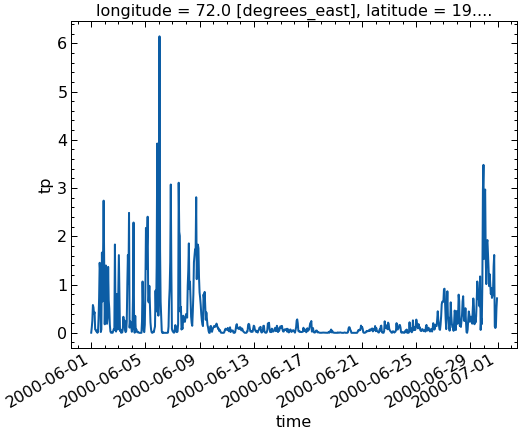

In [129]:
(p_era.tp.sel(latitude = 19, longitude = 72, time="2000-06")*1000).plot()

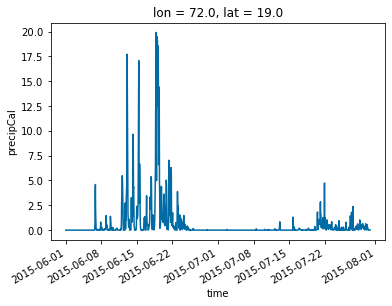

In [42]:
p1.plot()

In [43]:
# t2m = t2m.chunk(dict(time=5000, lat=40, lon=40))
# d2m = d2m.chunk(dict(time=5000, lat=40, lon=40))

In [44]:
# ds_comb = xr.merge([precip, t2m, d2m])

In [45]:
# ds_comb